<a href="https://colab.research.google.com/github/zmess24/personal-website-nextjs/blob/main/retrieval_augmented_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Recently, I've been absolutely obssessed with watching the TV show Suits, which is a fictional interpretation of the daily life and drama in a prestigous New York City lawfirm that stars Gabriel Macht as the illustrious lawyer Harvey Specter, and Patrick Adams as Harvey's boy-genius associate, Mike Ross. Without giving too much away, each episode runs roughy ~40 minutes and follows a basic a plot structure of:

* Harvey is assigned a new case or working on an ongoing case.
* Harvey asks Mike to help him by finding something they can use as leverage for a settlement.
* Cue a scene of Mike burried in the library digging through case files trying to find the needle in a haystack or having a eureka moment.
* Mike tells Harvey what he found, which leads to Harvey and/or Mike taking action with opposing counsel.

As "rinse and repeat" as that plot may sound, it is highly entertaining and in some ways, even inspiring. Harvey and Mike are players are the top of their game in their respective industry, and they almost always get the job done through a healthy combination of ingenuity and hardwork. However, as I was watching Mike perform yet another overnighter combing through 10 boxes of case files trying to uncover some missing link that would crack the case, I couldn't help but think "wouldn't this all be so much easier with RAG"? Which brings us to today's post!

RAG, or Retrieval Augmented Generation, is a phrase I would venture almost everyone has heard of in the last year or so, but most likely not one that everyone fully understands. In my opinion, with the current state of the AI ecosystem, it is one of the most important drivers of taking LLM usage from a "fun" experiment that can drive marginal value, to a business ready application that can yield enormous time-cost savings. So just what is it? How does it work? That will be the focus of todays post, so buckle up and get ready to learn about one of the most cutting-edge LLM techniques in the world!

### Table of Contents

* What is RAG?
* Library Import
* Downloading Data
* Embedding Stratigies
* Leveraging Metadata for References
* Setting up Lanchain
* Generating a Response
* Test Stratigies
* Conclusion

### What is RAG?

To begin, let's start with the most fundamental question of this post - just what is Retrieval Augemented Generation, and even more importantly, why do we need it?

Retrieval Augemented Generation, or "RAG" for short, is a technique by which an LLM application can leverage an external knowledge source to enhance it's response to a semantic query, and thereby improve it's response accuracy. The goal of RAG is to prevent what are called "hallucinations", which are instances where even though an LLM may express confidence in it's answer, the factual content may be entirely incorrect. For example, I'm sure we all remember the hilarious stories of Googles initial integration of Gemeni into Google Search, where it would occasionally output funny, albeit ridiculous responses like ["use non-toxic glue" to questions such as "how can I make cheese stick to pizza better"](https://www.bbc.com/news/articles/cd11gzejgz4o). While that specific instance is obviously (and hopefully) harmless, hallucinations can become far more impactiful when LLM's are relied upon to aid in real decision making, as the downstream effects of trusting incorrect or incomplete information can potentially disastrous.

Retrieval Augemented Generation is largely acheived through combining two specific components:

* **Retriever**: A system (such as vector database) that searches and retrieves relevant information from an external knowledge source for a provided query.
* **Generator**: A generative language model (such as GPT4o) that produces a response using both the user's query and the retrieved information as context.

And for a more granular level breakdown, here is a full architecture overview:

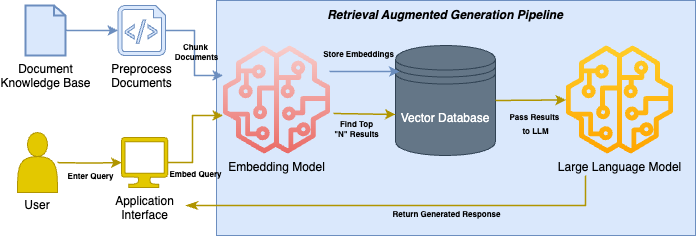

So that's what we'll be building today - a full, end-to-end RAG pipeline. Without further adu, let's get started.

### Library Import

I've you've been following along with me in AI journey, you'll know that the first step in all of my posts is to import the libraries we'll be using throughout the code to come.

Most of these should look familiar, as I've used almost all of them have been used in previous posts. However, there is one new library that I want to call out, which is `faiss`, or [Facebook AI Similarity Search](https://ai.meta.com/tools/faiss/). We'll dicuss why this library is important later on, but for now, it's enough to know that it will allow us to perform similarity searches on embeddings more performantly.  

In [1]:
try:
  # Data & Visualization Libraries
  import numpy as np
  import matplotlib.pyplot as plt
  import time

  # Typings
  from typing import Dict, List, Union, Optional
  from dataclasses import asdict

  # Text Preprocessing Libraries
  import nltk
  import spacy
  import re
  import string

  # ML & AI Models Libraries
  import openai
  import sklearn
  from sentence_transformers import SentenceTransformer

  # Database Libraries
  import faiss
except:
  !pip install faiss-cpu openai sentence-transformers -q
  import openai
  import faiss
  import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 39.9 MB/s eta 0:00:00


### Downloading Data

Next, let's download a few online articles to use as external sources of information for retrieval in our RAG system. The articles we'll use today will be focused on the topic of "AI's impact on the SaaS industry".

Since web scraping is not a core focus of this post (and the upcoming topics are more interesting anyway), I'm not going to walk through the mechanics of how the `scrape_articles` function works. However, if you're interested, I've included my source code in the addendum of this post for your review.

The `scrape_articles` function will return a Python list containing three dictionaries representing each of our three articles. Each dictionary will contain:

* A `url` key, mapped to the source URL of the article.
* A `test` key, which contains the scraped (and cleaned) raw text from each article.

In [51]:
# Article List
articles = [
  "https://www.8vc.com/resources/the-ai-services-wave-lessons-from-palantir-in-the-new-age-of-ai",
  "https://bowerycap.com/blog/insights/ai-the-services-as-software-era",
  "https://darioamodei.com/machines-of-loving-grace"
]

# Scrape the text from each article
documents = scrape_articles(articles)

# Print results
print(f"Document URL: {documents[0]['url']}")
print(f"Document URL: {documents[0]['text'][:200]}")

Document URL: https://www.8vc.com/resources/the-ai-services-wave-lessons-from-palantir-in-the-new-age-of-ai
Document URL: PostsOct 31, 2024ShareLast month, the first company I co-founded, Palantir, joined the S&P 500. For most of 20 years, the naive mainstream view of Palantir was that it was a "glorified consultancy" - 


### Document Chunking Explained

With three articles ready to go, we're ready to start building our retriever component, which in the context of this post will be a vector database. Given that I've written about vector databases and embeddings before, I won't spend a ton of time here covering then in depth ([Intro to Word Embeddings with Word2Vec](https://www.zacmessinger.com/posts/intro-to-word-embeddings-with-word2vec) and [Vector Databases and Cosine Similarity Searches](https://www.zacmessinger.com/posts/vector-databases-and-similarity-search). However, it's important to understand the fundamentals of what they are before moving forward, so here are some high level definitions:

* **Embeddings**: Word embeddings are numerical representations of words in vector form which can capture the semantic relationships of words and sentences to infer meaning.
* **Vector Database**: A vector database is a storage system that can save and efficiently query high-dimensional embeddings using distance metrics, enabling rapid similarity searches across massive datasets for applications like semantic search and recommendation engines.

While modern embedding models make it simple to convert text into vectors, the key challenge for retrieval augemented generation purposes lies in deciding how to segment our documents, especially when were dealing with large amounts of data. At first glance, a logical solution would be to convert each article into a single embedding, but this approach would dramatically reduce the precision and usefulness of our retrieval system. For example, consider a 500-page cookbook. If someone asks about making the perfect pizza crust, would you hand them the entire cookbook because you know it contains a pizza recipe somewhere inside, or direct them to the specific page about pizza dough? The answer is obvious - more focused information leads to better results.

This is where a process known as "document chunking" comes into play. By breaking documents into smaller, meaningful segments, we solve two fundamental challenges in retrieval systems. First, we ensure that our searches return precisely relevant information rather than entire documents containing mostly irrelevant content. Second, we create chunks that fit within the context windows of large language models, allowing them to process and understand the information effectively. This targeted approach not only improves search accuracy, but also enables our systems to generate more precise and helpful responses based on the most relevant portions of our documents, which is ultimately our end goal.

In order to chunk each of our three articles, we'll begin by defining a `Chunk` class. The class will contain a couple of different properties that will be helpful from a metadata perspective:

* `content`: The actual text content of the chunk
* `url`: Source URL where this chunk's content originated from
* `domain`: The website domain name the chunk was extracted from
* `token_count`: Number of tokens contained in this chunk
* `sentences`: List of individual sentences that make up this chunk's content

In [50]:
from dataclasses import dataclass
from typing import List, Dict, Any

@dataclass
class Chunk:
    """Represents a text chunk with metadata"""
    content: str
    url: str
    chunk_id: int
    token_count: int
    sentences: List[str]

### Document Chunking Decision Criteria

Next, we need to make three key decisions regarding how to chunk our articles: splitting technique, chunk size and overlap length. In case you've never heard of these terms before:

* **Splitting Technique** determines where the semantic boundries should be when breaking apart a document. Common boundries include the end of a sentence or the end of a paragraph.
* **Chunk size** refers to the target number of tokens each chunk should contain.
* **Overlap length** determines how many tokens from the preceding chunk will be included in the current chunk, ensuring contextual continuity between chunks.

These decisions are crucial for striking a balance between granularity and coherence in the processed text, and fortunately, we don't need to start from scratch. There is ample research available to guide us, so we'll use the following parameters for our chunking approach:

* **Splitting Technique**: We will split the text only at the end of sentences, as this is the simplest and most straightforward approach.
* **Chunk Size**: 1,024 tokens, [based a study by LlamaIndex](https://www.llamaindex.ai/blog/evaluating-the-ideal-chunk-size-for-a-rag-system-using-llamaindex-6207e5d3fec5).
* **Overlap Length**: 20%, [based on a study by MongoDB](https://www.mongodb.com/developer/products/atlas/choosing-chunking-strategy-rag/).

It's important to note that in a production setting, we would likely want to test with multiple values for each property to identify the combination that produces the best results. However, for this simple implementation, we'll just stick with these initial parameters since our goal is more to demonstrate how a retreival augemented system works, not create the best system possible.

To break down our articles into manageable chunks, we'll need to implement a few helper functions. We'll start by using `spacy`, a powerful natural language processing library, to split documents into individual sentences in a linguistically intelligent way.

In [18]:
from typing import Dict, List

def split_document_into_sentences(document: Dict[str, str]) -> List[str]:
  # Initialize spacy
  nlp = spacy.load("en_core_web_sm")
  if 'sentencizer' not in nlp.pipe_names: nlp.add_pipe('sentencizer')
  # Process documents and split it into sentences.
  doc = nlp(document["text"])
  # Return list of sentences
  return list(doc.sents)

# Test on first document & print results
sentences = split_document_into_sentences(documents[0])
print(f"Number of Sentences: {len(sentences)}")
print(f"First Sentence: {sentences[1]}")

Number of Sentences: 165
First Sentence: For most of 20 years, the naive mainstream view of Palantir was that it was a "glorified consultancy" - a services firm and not a real tech innovator building SaaS "products" or "platforms".


Now we'll implement `create_chunk`, a utility function that transforms a group of sentences and their associated metadata into a structured "Chunk" object using the `Chunk` class we defined above.

In [19]:
def create_chunk(sentences: List[str], document: Dict[str, str], chunk_id: int) -> Chunk:
  """Creates a single chunk from a list of sentences"""
  # Join list of sentences into string
  chunk_text = ' '.join(sentences)
  # Calculate token count for the chunkj
  token_count = sum(len(s) for s in sentences)
  # Return chunk
  return Chunk(
    content=chunk_text,
    url=document["url"],
    chunk_id=chunk_id,
    token_count=sum(len(s) for s in sentences),
    sentences=sentences.copy()
  )

Building on our previous functions, `chunk_document` orchestrates the entire chunking process by intelligently dividing a document into overlapping segments. It iterates through sentences (created using our `split_document_into_sentences` function) and combines them until reaching a specified token limit. To maintain context between chunks, it preserves two sentences of overlap between consecutive segments before using our `create_chunk` utility, resulting in a list of structured chunks that preserve both content and context.

In [20]:
from typing import List, Dict
from dataclasses import dataclass

def chunk_document(document: Dict[str, str], chunk_size: int = 512) -> List[Chunk]:
    """Chunks a document into overlapping pieces preserving sentence boundaries"""
    chunks = []
    current_sentences = []
    current_token_count = 0
    # Iterate over each sentence in document.
    for sentence in split_document_into_sentences(document):
        sentence_text = str(sentence).strip()
        sentence_length = len(sentence_text)
        # If the sum of the current token count + the next sentence is greater than the chunk size, create chunk.
        if current_token_count + sentence_length > chunk_size and current_sentences:
            # Create chunk from current sentences
            chunks.append(create_chunk(current_sentences, document, len(chunks)))
            # Keep last 2 sentences for overlap in next chunk
            current_sentences = current_sentences[-2:]
            current_token_count = sum(len(s) for s in current_sentences)
        # Add sentence to current sentences & increase current token count.
        current_sentences.append(sentence_text)
        current_token_count += sentence_length

    # Handle remaining sentences
    if current_sentences:
        chunks.append(create_chunk(current_sentences, document, len(chunks)))

    return chunks

Now lets tie it all together with a `chunk_documents` function, which acts as our primary document processor by taking a collection of documents and transforming them into a single cohesive set of chunks. It leverages our previously defined `chunk_document` function to process each document individually, while maintaining consistent chunk sizes (1024 tokens) and overlap (20%) across the entire collection.

In [21]:
# Define Chunk Size & Chunk Overlap Constants
CHUNK_SIZE=1024
CHUNK_OVERLAP=0.2
CHUNK_OVERLAP_SIZE = int(CHUNK_SIZE * CHUNK_OVERLAP)

def chunk_documents(documents: List[Dict[str, str]]) -> List[Chunk]:
  # Define list to hold all chunks
  all_chunks = []
  # Iterate over each document
  for document in documents:
    # Break document into chunks
    chunks = chunk_document(document, chunk_size=CHUNK_SIZE)
    # Add chunks to all_chunks list
    all_chunks.extend(chunks)
  # Return all chunks
  return all_chunks

all_chunks = chunk_documents(documents)
print(f"Number of chunks: {len(all_chunks)}")

Number of chunks: 208


Now that we have our text chunks prepared, all that's left to do is convert them into vector embeddings. For this implementation, we'll use Google's SentenceTransformer (specifically the [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) model), as it's a model I've used in previous posts. While there are many powerful embedding models available, SentenceTransformer offers an excellent balance of performance and accessibility, with the added benefits of being open-source and requiring no authentication.

In [22]:
# Initialize Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

def get_embedding(text):
    """Returns embedding for text"""
    return model.encode(text)

# Use list comprehension to terate over each chunk and return embedding
document_embeddings = [get_embedding(chunk.content) for chunk in all_chunks]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Voila! We've now successfully processed our articles into 208 distinct chunks, each with a corresponding vector embeddings. While this preprocessing step may have been technically complex, the work completed will form the bedrock for our retrieval system andc enable us to accurately search our corpus of article text for semantically similar vectors.

With the "what" of search system completed, we're ready to move onto the "how".


### KNN Complexities

Previously in my [Vector Databases and Cosine Similarity Searches](https://www.zacmessinger.com/posts/vector-databases-and-similarity-search) post, we explored the fundamentals of vector search by implementing K-Nearest Neighbors (KNN), with the core concept being that we can find the semantic similarity between texts by measuring the angular distance between their vector representations. As a refresher, when two vectors point in nearly the same direction (small angle), they represent semantically similar content, while vectors pointing in different directions (large angle) indicate dissimilar content. This angular relationship is quantified using an linear algebraic concept known as cosine similarity, which provides a mathematical foundation for comparing vector embeddings.

While KNN performs effectively with small datasets, it faces significant scaling challenges as data volume increases. These performance limitations stem from two computationally expensive requirements:

1.   First, the algorithm must calculate cosine similarity between the query vector and every single vector in the database
2.   Second, it needs to sort all these similarity scores to identify the k closest matches.

This exhaustive comparison and sorting process makes KNN increasingly impractical as the dataset grows, since the computational cost rises linearly with the number of vectors in the database. To demonstrate this, lets plot the search time in seconds against fictional vector datasets of various sizes:

<ipython-input-7-7d964421ee76>:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([format_number(x) for x in plt.gca().get_xticks()])


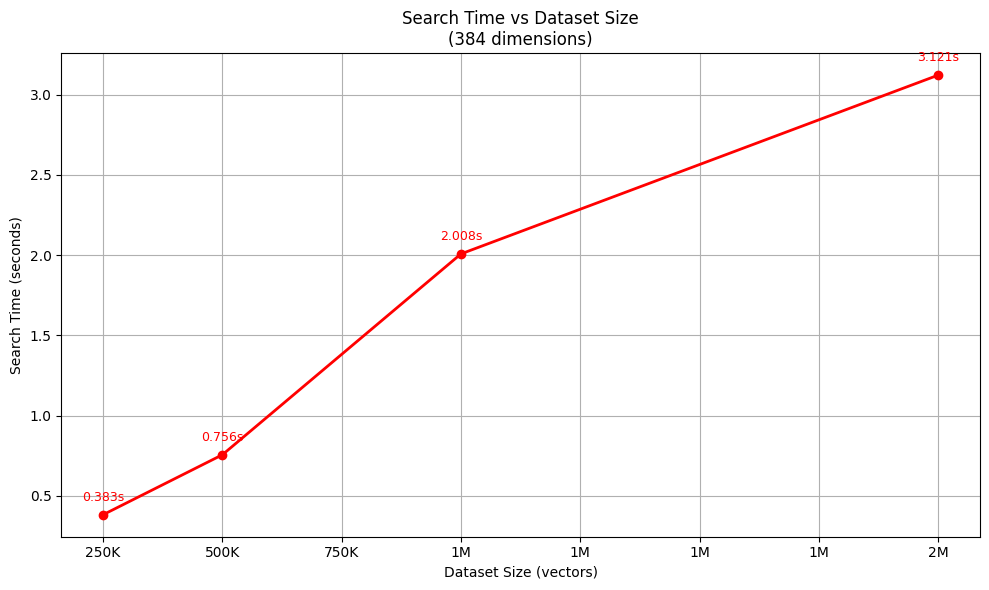

In [7]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import gc

def format_number(x):
    """Format numbers for axis labels"""
    if x >= 1_000_000:
        return f'{int(x/1_000_000)}M'
    elif x >= 1_000:
        return f'{int(x/1_000)}K'
    return str(int(x))

def generate_embeddings(n_samples, dim=384):
    """Generate random embeddings and normalize them"""
    embeddings = np.random.normal(0, 1, (n_samples, dim)).astype('float32')
    return normalize(embeddings)

def measure_knn_search(embeddings: np.ndarray, query: np.ndarray, k: int) -> float:
    """Measure time for KNN search."""
    # Train Model
    nn = NearestNeighbors(n_neighbors=k, metric='cosine')
    nn.fit(embeddings)
    # Measure Search Time
    start_time = time.time()
    nn.kneighbors(query)
    search_time = time.time() - start_time
    # Delete model from memory
    del nn
    return search_time

def create_search_time_plot(dataset_sizes, search_times_list, dim=384, figsize=(10, 6)):
    """
    Creates a visualization comparing search times across different dataset sizes.
    """
    # Convert single list of times to list of lists if necessary
    if not isinstance(search_times_list[0], list):
        search_times_list = [search_times_list]

    # Create the figure with specified size
    plt.figure(figsize=figsize)

    # Define colors and labels based on number of methods
    colors = ['r', 'b', 'g', 'purple', 'orange']
    methods = ['KNN', 'FAISS'] if len(search_times_list) == 2 else ['Search Time']

    # Plot each search method
    for i, times in enumerate(search_times_list):
        method = methods[i] if i < len(methods) else f'Method {i+1}'
        color = colors[i % len(colors)]

        plt.plot(dataset_sizes, times, f'{color}-',
                marker='o',
                label=method,
                linewidth=2)

        # Add time labels for each point
        for size, time in zip(dataset_sizes, times):
            y_offset = 10 if i == 0 else -15  # Adjust label position based on method
            plt.annotate(
                f'{time:.3f}s',
                (size, time),
                textcoords="offset points",
                xytext=(0, y_offset),
                ha='center',
                fontsize=9,
                color=color
            )

    # Format the x-axis to show numbers in K/M format
    plt.gca().set_xticklabels([format_number(x) for x in plt.gca().get_xticks()])
    # Add labels and title
    plt.xlabel('Dataset Size (vectors)')
    plt.ylabel('Search Time (seconds)')
    plt.title(f'Search Time vs Dataset Size\n({dim} dimensions)')
    # Add grid and legend if multiple methods
    plt.grid(True)
    if len(search_times_list) > 1:plt.legend(fontsize=10)
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Test with increasing dataset sizes
SIZES = [250000, 500000, 1000000, 2000000]
DIM = 384
K = 5
knn_times = []

for size in SIZES:
    # Generate Random Dataset
    embeddings = generate_embeddings(size, DIM)
    # Generate Random Query
    query = generate_embeddings(1, DIM)
    try:
        # Measure KNN Search Time
        knn_search_time = measure_knn_search(embeddings, query, K)
        knn_times.append(knn_search_time)
    finally:
        # Cleanup to manage memory
        del embeddings
        gc.collect()

create_search_time_plot(SIZES, knn_times)

We can clearly see the linear relationship between dataset size and search time in KNN, as each time we double the size of our dataset, we observe our search time roughly doubling as well. While this might not be an issue for our meager dataset of 208 embeddings, this linear growth in processing time makes KNN unsuitable for real-world applications that require fast search times across large datasets. So the question becomes - how can we improve performance?

### Facebook AI Similarity Search (FAISS)

FAISS (Facebook AI Similarity Search), [introduced by Facebook in 2017](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/), is a powerful library that solves a critical challenge in machine learning: how to efficiently search through massive collections of high-dimensional vectors. While traditional similarity search methods slow down linearly as data grows (as we just observed), FAISS offers a suite of specialized indexing strategies that make searching through millions or even billions of vectors practical. At its simplest level, FAISS provides IndexFlatIP, a foundational index that enhances the basic nearest neighbor search we discussed earlier by leveraging optimized matrix operations and efficient vector computations. Though IndexFlatIP is just one of many available indexes in FAISS, understanding it provides an excellent entry point for exploring FAISS's more sophisticated indexing strategies, each designed to handle different scales and performance requirements.

IndexFlatIP stands for Index Flat Inner Product, and performs similarity search by storing vectors in their raw form ("Flat") and comparing them using the inner product ("IP") distance metric. Think of it as the simplest form of a vector index, where "Flat" indicates no compression or complex data structures are used - the vectors are stored exactly as they are, much like keeping books arranged in a single row on a shelf rather than organizing them into sections.

In order to demonstrate the performance gains afforded to us by leveraging FAISS, let's create fictional dataset of 2 million embeddings, which was the upper bound limit of the test we ran above.

In [10]:
# Create 2M numpy vector
embeddings = generate_embeddings(2000000, DIM)
# Generate query vector
query = generate_embeddings(1, DIM)

The key to FAISS's performance with IndexFlatIP lies in how it handles vector computations using efficient matrix multiplication rather than comparing vectors one by one, which is a [topic I've covered](https://www.zacmessinger.com/posts/fun-with-linear-algebra-and-matrices) previously if you're interested in exploring the mechanics of the math. In practical terms, instead of computing similarities sequentially:

In [11]:
def cosine_similarity(query_vector, vectors):
  similarities = []

  for vector in vectors:
    # Ensure the vectors are numpy arrays
    vector_a = np.array(vector)
    vector_b = np.array(query_vector)
    # Calculate the dot product
    dot_product = np.dot(vector_a, vector_b)
    # Calculate the magnitudes of the vectors
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)
    # Calculate the cosine similarity
    cosine_sim = dot_product / (magnitude_a * magnitude_b)
    similarities.append(round(cosine_sim, 8))

  return similarities

FAISS leverages optimized matrix operations to compute all similarities simultaneously:

In [8]:
def cosine_similarity_matrix(query_vector, vectors):
    # Reshape query vector to 2D array (1, dimensions)
    query_vector = np.array(query_vector).reshape(1, -1)
    # Calculate dot products for all vectors at once
    dot_products = query_vector @ vectors.T
    # Calculate magnitudes
    query_magnitude = np.linalg.norm(query_vector)
    vector_magnitudes = np.linalg.norm(vectors, axis=1)
    # Calculate cosine similarities
    similarities = dot_products / (query_magnitude * vector_magnitudes)

    return np.round(similarities.ravel(), 8)

This matrix-based approach isn't just a different way of writing the code - it fundamentally transforms how the computation is performed at the hardware level. Modern CPUs and GPUs are specifically designed to handle matrix operations efficiently, using techniques like vectorized instructions and parallel processing. When you multiply matrices, the hardware can perform multiple calculations simultaneously, taking advantage of memory caching and specialized arithmetic units. This is why a single matrix multiplication can be orders of magnitude faster than performing the same calculations one by one, especially when dealing with millions of vectors. Aditionally, FAISS leverages efficient sorting algorithms & data structures (like [max heap sort](https://www.geeksforgeeks.org/heap-sort/)) for the finding the top `n` records to further optimize the retrieval process.

Implementing FAISS is very straight forward - we simply initialize the FAISS with the number of dimensions in the matrix, and then add our embeddings to the index:

In [ ]:
# Get embedding dimension length
embedding_dimension = len(embeddings[0])

# Build FAISS index
index = faiss.IndexFlatIP(embedding_dimension)
index.add(np.array(embeddings).astype('float32'))

As a validation of the performance implications of FAISS, lets now plot the FAISS search times against traditional KNN. Note that the search times for KNN might be slightly different than above due to us generating a new random embeddings list:

<ipython-input-7-7d964421ee76>:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([format_number(x) for x in plt.gca().get_xticks()])


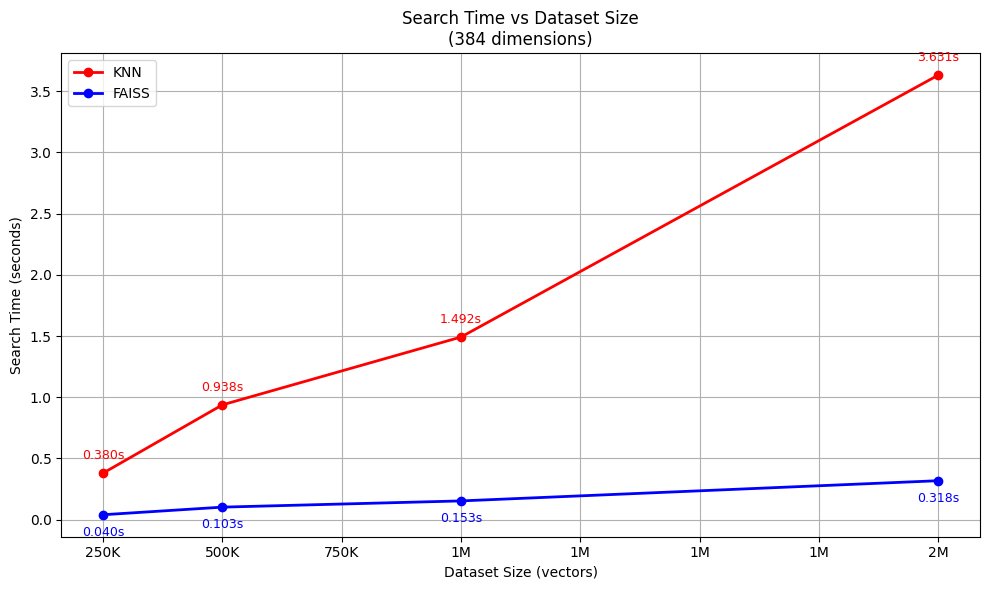

In [8]:
def measure_faiss_search(embeddings: np.ndarray, query: np.ndarray, k: int) -> float:
    """Measure time for FAISS search."""
    # Create copies for normalization since FAISS modifies in place
    embeddings_copy = embeddings.copy()
    query_copy = query.copy()
    faiss.normalize_L2(embeddings_copy)
    faiss.normalize_L2(query_copy)
    # Get embedding dimension length
    embedding_dimension = len(embeddings[0])
    # Build FAISS index
    index = faiss.IndexFlatIP(embedding_dimension)
    index.add(embeddings_copy)
    # Measure search times.
    start_time = time.time()
    D, I = index.search(query_copy, k)
    search_time = time.time() - start_time

    del index, embeddings_copy, query_copy
    return search_time

# Test with increasing dataset sizes
SIZES = [250000, 500000, 1000000, 2000000]
DIM = 384
K = 5
knn_times = []
faiss_times = []

for size in SIZES:
    # Generate Random Dataset
    embeddings = generate_embeddings(size, DIM)
    # Generate Random Query
    query = generate_embeddings(1, DIM)
    try:
        # Measure KNN Search Time
        knn_search_time = measure_knn_search(embeddings, query, K)
        knn_times.append(knn_search_time)
        # Measure FAISS Search Time
        faiss_search_time = measure_faiss_search(embeddings, query, K)
        faiss_times.append(faiss_search_time)
    finally:
        # Cleanup to manage memory
        del embeddings
        gc.collect()
# Plot
create_search_time_plot(SIZES, [knn_times, faiss_times])

### Setting up a Vector Database

Our retriever component is nearly complete, and the final piece is implementing our vector database. To do so, we'll build upon the architecture from my [previous post](https://www.zacmessinger.com/posts/vector-databases-and-similarity-search), with some slight modifications to make the search process more robust for a retrieval augmented generation system. Specifically, our database design will incorporate two carefully synchronized components establised during the intilization process:

* A document store that maintains our textual data and metadata
* A vector index that enables efficient similarity search.

The 1:1 mapping between the store and the index is fundamental to our system's accuracy, as it ensures that when we find similar vectors, we can trace them back to their exact source documents to deliver rich, contextual results. Importantly, this rich context can enable intelligent filtering of our results through implementing similarity thresholds - for example, we might choose to only return embeddings that have a similarity score of greater than 70%, ensuring we only uses genuinely relevant matches.

In [48]:
class VectorDatabase:
    def __init__(self, index_path: Optional[str] = None, documents_path: Optional[str] = None):
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.dimension = self.model.get_sentence_embedding_dimension()
        # For IndexFlatIP, we should normalize vectors before adding them
        self.index = faiss.IndexFlatIP(self.dimension)
        self.documents = []

    def initialize(self, chunked_documents: List[Any], embeddings: np.ndarray):
        # Store documents and their metadata
        self.documents = [{
              'content': doc.content,
              'metadata': {
                  'url': doc.url,
                  'chunk_id': doc.chunk_id,
                  'token_count': doc.token_count,
                  'sentences': doc.sentences
              }} for doc in chunked_documents]
        # Normalize vectors before adding to IndexFlatIP
        faiss.normalize_L2(embeddings)
        self.index.add(embeddings.astype('float32'))

    def generate_embedding(self, query: str) -> np.ndarray:
        # Generate and normalize the embedding
        embedding = self.model.encode(query)
        embedding = embedding.astype('float32').reshape(1, -1)
        faiss.normalize_L2(embedding)
        return embedding

    def search(self, query: str, k: int = 5) -> List[Dict]:
        # Generate query embedding
        query_vector = self.generate_embedding(query)
        # Search the index (no reshape needed since generate_embedding handles it)
        similarities, indices = self.index.search(query_vector, k)
        results = []
        for dist, idx in zip(similarities[0], indices[0]):
            # Make index is valid
            if idx < len(self.documents):
                # Find document chunk in documents list
                doc = self.documents[idx].copy()
                # Add score property assigned to the distance
                doc['score'] = float(dist)
                # Append to results
                results.append(doc)
        return results

Let's validate our implementation by instantiating our vector database and populating it with our prepared document chunks and embeddings. We'll evaluate its performance through both automated search queries and manual inspection of the results, ensuring our similarity search functions as intended.

In [52]:
# Initialize database
db = VectorDatabase()
# Initialize with your chunked documents and embeddings
db.initialize(all_chunks, np.array(document_embeddings))
# Search
results = db.search("How do the best tech-services companies use technology to drive operating?", k=5)
# Print results
for result in results:
    print(f"Score: {result['score']:.3f}")
    print(f"Content: {result['content'][:200]}...")
    print(f"URL: {result['metadata']['url']}")
    print("-" * 80)

Score: 0.586
Content: The key to going after these workflows (and the spend associated with them) is combining technology with human expertise. This approach doesn't just create a lot of value for customers - it allows com...
URL: https://www.8vc.com/resources/the-ai-services-wave-lessons-from-palantir-in-the-new-age-of-ai
--------------------------------------------------------------------------------
Score: 0.568
Content: The tech-enabled services wave will sharpen this paradigm. Creating successful businesses will require hiring top technical and operational talent: people who combine IQ with EQ. It will also require ...
URL: https://www.8vc.com/resources/the-ai-services-wave-lessons-from-palantir-in-the-new-age-of-ai
--------------------------------------------------------------------------------
Score: 0.522
Content: Many great companies were built through tight integration of in-house software and best-in-class operating practices. But there are also many recent examples of VC-ba

### Setting up our Generator

We're almost at the finish line! With our retriever component complete, all that's left is connect an LLM as a generator to complete our end-to-end RAG system. Given the extensive foundation we just built for our retriever, this last piece of the puzzle will be very straight forward.

In this example, we're going to roll with using OpenAI's 4.0 model given the robustness of it's API, although any model would do. Depending on the complexity and use cases your RAG pipeline is supporting, it's possible that you many even want to leverage multiple model depending on the query classification, since different LLM's can excel at different tasks.



In [2]:
from openai import OpenAI

# API Key (note, always keep this hidden in a .env file and never expose it publically)
api_key = "sk-proj-1234..."
# Init OpenAI client
client = OpenAI(api_key=api_key)
# OpenAI model name we would like to use
model = "gpt-4-turbo-preview"

Next, we'll design a class for orchestrating the the entire Retrieval Augmented Generation process through a series of carefully sequenced steps, almost all of which we have coded a solution for. The pipeline will work like this:

1. When a user initiates a search, the process begins with the `search` method, which serves as the main entry point.
2. This method first queries our vector database to find the k most similar documents to the user's question (by default, k=5).
3. These results are then passed to the `format_context` method, which transforms them into two key components: a formatted context string that contains the content and relevance scores of each matching document, and a reference list that maps each document to its source URL.
4. The `generate_response` method is then called, which coordinates the interaction with the language model. This method first calls `generate_query` to construct a detailed prompt that combines our retrieved context, reference list, and the user's original question with specific instructions about citation formatting.
5. The prompt is then sent to our chosen language model, asking it to synthesize an answer that cites its sources using academic-style citations.
6. Finally, the search method packages everything together in a comprehensive response dictionary that includes not only the generated answer but also the source references, relevance scores, and the total number of unique sources used.

This setup exemplifies a key principle of RAG systems: rather than just generating an answer from the language model's training data, we're guiding it to work with specific, retrieved information and requiring it to cite its sources. The class effectively bridges the gap between information retrieval (finding relevant documents) and natural language generation (creating coherent, well-cited responses based on those documents).

In [77]:
from typing import Tuple, Dict, List

class RAGGenerator:
    def __init__(self, client: Dict, model: str = "gpt-4-turbo-preview"):
        # Initialize OpenAI with model name and API Key
        self.client = client
        self.model = model

    def format_context(self, results: List[Dict]) -> Tuple[str, str]:
        """Format search results into context and references."""
        contexts = []
        references = {}

        for idx, result in enumerate(results, 1):
            contexts.append(f"""
                [{idx}] Content: {result['content']}
                Relevance Score: {result['score']:.2f}
            """)
            references[str(idx)] = result['metadata']['url']

        full_context = "\n".join(contexts)
        reference_list = "\n".join(f"[{idx}] {url}" for idx, url in references.items())
        return full_context, reference_list

    def generate_query(self, context: str, references: str, query: str) -> str:
        """
        Generate the prompt for the LLM including context, references, and query.
        """
        return f"""
        You are a helpful AI assistant. Use the provided excerpts to answer the user's question.
        Use academic-style citations by referring to sources with numbers in square brackets [1], [2], etc.

        When citing information, place the citation number immediately after the relevant information.
        For example: "The technology sector grew by 25% in 2023[1], while AI investments doubled[2]."

        Context:
        {context}

        References:
        {references}

        Question:
        {query}

        Important:
        1. Use [n] citations for specific information
        2. Only cite the provided sources
        3. Place citations immediately after the relevant information
        4. Include a "References" section at the end of your response

        Answer the question:"""

    def generate_response(self, query: str, context: str, references: str) -> str:
        """Generate LLM response using formatted context."""
        # Generete prompt with retrieved context and source references
        prompt = self.generate_query(context, references, query)
        # Ask LLM to generate response
        response = self.client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": "You are a helpful AI assistant that provides accurate, well-cited answers based on the given context."},
                {"role": "user", "content": prompt}
            ],
            temperature=0,
            max_tokens=1000
        )
        # Return response
        return response.choices[0].message.content

    def search(self, query: str, db, k: int = 5) -> Dict:
        """Perform RAG search and return formatted results."""
        # Search db for 5 most similar results
        results = db.search(query, k=k)
        # Extract context and source references
        context, references = self.format_context(results)
        # Use LLM to synthesize data
        answer = self.generate_response(query, context, references)
        return {
            'answer': answer,
            'sources': references,
            'relevance_scores': [r['score'] for r in results],
            'num_sources': len(set(r['metadata']['url'] for r in results))
        }

With that, let's give it a whirl!

In [76]:
# Initialize generator
rag = RAGGenerator(client=client, model=model)

# Perform search
results = rag.search("How do the best tech-services companies use technology to drive operating?", db)

print(results["answer"])

The best tech-services companies leverage technology to enhance their operating leverage in two significant ways. Firstly, they create a unique value proposition by offering services that are faster, cheaper, and of better quality than those provided by legacy competitors[1]. This approach not only meets but exceeds customer expectations, setting a new standard in service delivery. Secondly, these companies improve their unit economics by significantly reducing labor costs as part of their Cost of Goods Sold (COGS). This reduction in labor costs not only alters the margin structure in favor of the company but also simplifies the process of scaling the business when compared to incumbent competitors[1]. By focusing on these strategies, tech-services companies are able to capture a larger market share and increase their resilience against future advancements in AI and technology.

References:
[1] https://www.8vc.com/resources/the-ai-services-wave-lessons-from-palantir-in-the-new-age-of-a

We can see that the answer returned from our RAG pipeline aligns perfectly with what our LLM provided to us!

```
1. Create a unique value proposition with faster, cheaper, and better service quality than legacy providers.

2. Improve unit economics by removing big chunks of labor from COGS; both altering the margin structure and making the business easier to scale relative to incumbent competitors.
```

### Conclusion

Thank you for joining me on this exploration of Retrieval Augmented Generation (RAG)! We've covered significant ground in our naite implementation, from understanding the fundamental concepts how to chunk documents, to implementing a practical, working system. As we venture into 2025, [widely anticipated as the year of "AI Agents"](https://finance.yahoo.com/news/from-microsoft-to-nvidia-the-ai-agents-are-coming-in-2025-141314094.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAABz-bct9MJgrkeg_NqDLJ-FIj72RHYXeGnoGXgf0Q5iqs-5NQPNEZzfk3cZ-FZl0nYoYUapCjF4_Dk8tuh31flaSv5u1jJXipHeg4wJVmOhEtXs26B1LMcdHFHMGjTH3kwXsjjt7ToPtzY0yGtJKQImNF1TESvqYB994l856y5W7), RAG technologies will become increasingly central to AI applications, serving as the foundation for more intelligent, context-aware systems that can effectively leverage both historical knowledge and real-time information.

I'm excited to continue diving deeper down the ever expanding rabbit hole of AI in 2025, and all the promising benefits that come with further innovation - it's amazing to think of how far we have come in the ~2 years since ChatGPT was first released. Have a great New Year, and I'll catch you next time!

### Appendix (Scrape Articles Code)

In [14]:
from typing import List, Dict
import requests
from bs4 import BeautifulSoup

def clean_text(text: str) -> str:
    """
    Cleans text by removing special characters and normalizing quotes and apostrophes.
    """
    # Fix the â + escaped apostrophe pattern
    text = re.sub(r'â\\x80\\x99', "'", text)
    text = re.sub(r'â\x80\x99', "'", text)

    # Replace other special characters
    replacements = {
        '\x80\x9c': '"',  # opening double quote
        '\x80\x9d': '"',  # closing double quote
        '\x80\x98': "'",  # opening single quote
        '\x80\x99': "'",  # closing single quote
        '\x80\x93': '-',  # en dash
        '\x80\x94': '--', # em dash
        '\xa0': ' ',      # non-breaking space
        'â': '',          # remove any remaining â characters
    }

    for old, new in replacements.items():
        text = text.replace(old, new)

    # Remove any remaining non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Normalize whitespace
    text = ' '.join(text.split())

    return text

def scrape_articles(urls: List[str]) -> List[Dict[str, str]]:
    """
    Scrapes text content from a list of article URLs.
    Returns a list of dictionaries with 'url' and 'text' keys.
    """
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    # List to store documents
    documents = []

    for url in urls:
        try:
            time.sleep(2)
            response = requests.get(url, headers=headers)
            response.raise_for_status()

            soup = BeautifulSoup(response.text, 'html.parser')

            # Remove unwanted elements
            for element in soup.find_all(['script', 'style', 'nav', 'header', 'footer']):
                element.decompose()

            # Extract text content based on site
            content = None
            if '8vc.com' in url:
                content = soup.find('div', class_='insight_main-block')
            elif 'bowerycap.com' in url:
                content = soup.find('div', class_='rich-text')
            elif 'arstechnica.com' in url:
                content = soup.find('div', class_='content-container')
            else:
                content = soup.find('article') or soup.find('main') or soup.body

            if content:
                # Scrape text and strip of preceding and trailing whitespace
                text = content.get_text().strip()
                # Clean the text if it exists
                cleaned_text = clean_text(text) if text else "No content found on the page"
            else:
                cleaned_text = "No content found on the page"

            # Add document to list
            documents.append({
                "url": url,
                "text": cleaned_text
            })

        except Exception as e:
            # Add error document to list
            documents.append({
                "url": url,
                "text": f"Error scraping URL: {str(e)}"
            })

    return documents

#